In the previous lesson, you saw that OLS pins down the coefficients of the linear regression model by minimizing the sum of the model's squared error terms. In addition to being relatively simple from a computational standpoint, OLS also has several appealing theoretical properties. The best-known of these properties is associated with the *Gauss-Markov* theorem, which states that the OLS estimator is the *best linear unbiased estimator* (BLUE) under certain conditions. This means that at a high level, OLS produces the "best" unbiased estimates of the parameters $\beta$ in the sense that its estimates have the smallest variance. *Unbiased* means that the average estimates for the parameters will converge to true parameter values; in other words, OLS will estimate the correct parameter values, on average). This is an important restriction; as you will discover later, there are other linear models (such as ridge and lasso regression) that are potentially biased but nonetheless may be preferable due to other considerations.

There are a number of assumptions underlying the Gauss-Markov theorem, some of which are quite strong and frequently violated when modeling real-life scenarios. Although they vary considerably in terms of verifiability and impact when violated, it is important to carefully consider all of the underlying assumptions when building linear regression models. If violations of these assumptions are detected, there may be specific techniques for addressing or mitigating these issues; these techniques can and should be implemented before retraining the model. In this lesson, you'll review these assumptions using your medical costs model from the previous lesson.


**Note:** The exact number of Gauss-Markov conditions may vary between different sources. So don't get surprised if you see in some places that the number of Gauss-Markov conditions is four, five, or six. This is because some of the conditions can be derived from the others. For the sake of clarity, you'll learn about Gauss-Markov conditions as six assumptions.

Here are the main topics that will be covered in this lesson:

* Correct model specification
* Exogeneity
* Homoscedasticity
* (No perfect) multicollinearity
* Uncorrelated error terms
* Normality of the errors

## Medical costs model

You'll use your medical costs model from the previous lesson to explore Gauss-Markov conditions. First, you need to import the relevant libraries and do the feature-engineering steps. Then you will fit your model using OLS.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine, text

# Display preferences
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'medicalcosts'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# insurance_df = pd.read_sql_query(text('SELECT * FROM medicalcosts'), con=engine.connect())
with engine.begin() as conn:
    query = text("""SELECT * FROM medicalcosts""")
    insurance_df = pd.read_sql_query(query, conn)

# No need for an open connection, because you're only doing a single query
engine.dispose()

insurance_df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.900
1,18,male,33.770,1,no,southeast,1725.550
2,28,male,33.000,3,no,southeast,4449.460
3,33,male,22.705,0,no,northwest,21984.500
4,32,male,28.880,0,no,northwest,3866.860
5,31,female,25.740,0,no,southeast,3756.620
6,46,female,33.440,1,no,southeast,8240.590
7,37,female,27.740,3,no,northwest,7281.510
8,37,male,29.830,2,no,northeast,6406.410
9,60,female,25.840,0,no,northwest,28923.100


In [2]:
insurance_df["is_male"] = pd.get_dummies(insurance_df.sex, drop_first=True)
insurance_df["is_smoker"] = pd.get_dummies(insurance_df.smoker, drop_first=True)

In [3]:
# `Y` is the target variable
Y = insurance_df['charges']
# `X` is the feature set which includes the
# `is_male` and `is_smoker` variables
X = insurance_df[['is_male','is_smoker']]

# Create a `LinearRegression` model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# Fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [  -65.37868556 23622.13598049]

Intercept: 
 8466.035592512446


## Assumption 1: Correct model specification

The first assumption is that the model is correctly specified. In other words, the mathematical relationship between the response and the features posited by the model actually reflects the "true data-generating process" that produces the observations. This inherently contains a couple of smaller yet very important assumptions within it:

- All of the factors that impact the response have been captured in the model; in other words, there are no omitted variables.
- The functional form of the model is correct; in other words, the response is actually a linear combination of the estimated parameters.

The second condition is worth a deeper dive, because it is frequently misinterpreted. It is tempting to think that linear regression corresponds to models that are linear in the features—straight lines, planes, or hyperplanes in a geometric sense. However, because the features in the model are treated as fixed, error-free values, you can **create new features that are nonlinear transformations of the original features**. Then you can estimate parameters for them in the same manner as the original features themselves. For example, the following linear model captures a quadratic relationship between the target $y$ and a feature $x_2$:

$$ y = \beta_0 + \beta_1x_1 + \beta_2x_2^2 + \epsilon$$

This model is linear in the parameters, and can thus be solved using OLS.

As mentioned earlier, linear regression modeling is quite flexible in capturing nonlinear relationships between target and features. For example, in equation 1, the relationship between the $y$ and $x$ is indeed quadratic. Below, consider how linear regression correctly estimates the intercept and the coefficients of the following model using synthetic data.

$$ y = 1 + 2x_1 + 3x_1^2$$



Coefficients: 
 [2. 3.]

Intercept: 
 0.9999999997671694


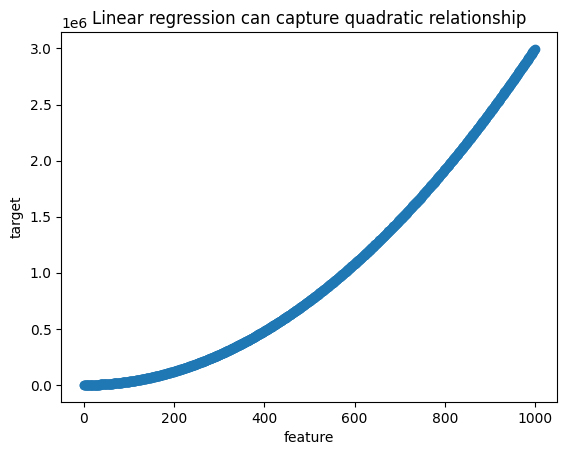

In [4]:
df = pd.DataFrame()

# Data from 0-999
df["X"] = np.arange(0,1000,1)
# Take the square of X
df["X_sq"] = df["X"]**2

# This is your equation: Y = 1 + 2*X + 3*X^2
df["Y"] = 1 + 2*df["X"] + 3*df["X_sq"]

# Fit a linear regression where target is `Y`
# and features are `X` and `X^2`
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df[["X","X_sq"]],df["Y"])

# Predictions of the linear regression
predictions = lrm_example.predict(df[["X","X_sq"]])

# Print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# Plot the estimated `Y` and `X`
# The relationship should be quadratic
plt.scatter(df["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

As you can see, the linear regression model correctly estimated the true coefficients and captured the quadratic relationship between the target and the feature.

In contrast, the following model is not amenable to OLS regression; it isn't linear in the parameters and cannot be re-expressed as such through mathematical transformations:

$$ y = \beta_0 + \beta_1x_1 + \beta_1^2x_1 + \epsilon $$  

Parameter estimation for such models falls in the domain of nonlinear regression, which is beyond the scope of this program.

### Verifying the assumption

Unfortunately, verifying this assumption requires knowledge of the "true data-generating process", which is very rarely the case when dealing with complex phenomena such as weather, house prices, etc. However, to sanity-check the model and guide feature engineering, you can ponder the following question: is it realistic that the marginal effect of this feature on the target is constant?

## Exogeneity

Another key assumption in linear regression modeling is the *exogeneity* assumption. This assumption can be expressed mathematically as follows:

$$\mathbb{E}(\epsilon|X) = 0$$

The $\mathbb{E}$ symbol indicates the *expectation operator*, which is usually associated with calculating means. This assumption is sometimes referred to as the *mean independence* assumption, since the mean of the error term is independent of the feature values. Informally, this assumption implies that variation of the error term is not explained by the variation in the features. This seems intuitively reasonable, because the error term is supposed to reflect "unpredictable" variation that the features (the drivers of the "predictable" variation in the response) cannot explain.

**Note:** Strictly speaking, this informal explanation overstates the strength of the assumption, as it describes statistical independence rather than mean independence. Mean independence characterizes the relationship between the features and central tendency of the error term. It's possible to fulfill the mean independence criteria while still having a relationship between the error term and the features; the variance may be affected by the features instead of the mean. However, you can often make additional assumptions that amount to statistical independence when combined with this assumption. For example, you may assume that the errors are conditionally normally distributed.
  
Although the formula above neatly captures an essential underlying assumption of the Gauss-Markov theorem, it has two relatively simpler consequences that are usually presented as separate assumptions instead. These are the next two assumptions covered below.

## Assumption 2: The error term's expected value

This second assumption states that the expected value of the error term should be zero. In mathematical terms, this is denoted as follows:

$$\mathbb{E}(\epsilon) = 0$$

Mathematically, this is a direct consequence of the applying the law of iterated expectations to the formula previously stated in the exogeneity assumption; intuitively, if the expected error is zero for any given set of feature values, the expected error should intuitively be zero over all possible feature values as well. This must be true for the error term to represent "noise"; if the expected error was anything other than zero, there would be no way to separate its effect from the intercept term.

### Verifying the assumption

Unfortunately, the assumptions that stem from exogeneity cannot be statistically verified. A common trap is to conflate the residuals of the fitted model with the error term and assume that the assumption is met if the mean of the residuals is zero. Although the residuals would ideally reflect the behavior of the error term, they only do so if the model is correctly specified—something that you usually cannot verify (see the first assumption). Furthermore, the mean of the residuals is guaranteed to be zero as a consequence of model construction, regardless of the value of the error term (which is an unobservable quantity). Here's an intuitive example: if the error term for a linear data-generating process is normally distributed with a mean of 1, a linear regression model fitted to a corresponding sample will simply overestimate the intercept term by 1 as part of the model-fitting process. This is because the "noisy" systematic effect of the error term on the response is indistinguishable from the "signal" of the intercept term.

In your medical costs model, you can see this happening:

In [5]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: 1.2180975378005138e-12


## Assumption 3: Uncorrelated features and errors

Another important consequence of the exogeneity assumption is that the error term is assumed to be uncorrelated with all of the features. This can be mathematically expressed as follows:

$$\mathbb{E}(X'\epsilon) = 0 $$  

In essence, this implies that there is no degree of linear association between the error term and any of the features. This is sensible for the same reasons as assumption 2—if linear dependencies existed between the error term and the features, there would be no way to separate them when performing parameter estimation.

### Verifying the assumption

The same caveats apply as in assumption two. In general, there is no statistical method for verifying this from the data—don't fall into the trap of computing the covariance matrix between the residuals and features and drawing conclusions from it. The covariance is guaranteed to be 0 as a consequence of model construction!

## Exogeneity, revisited

It is frequently stated that exogeneity is one of the most critical assumptions of linear regression, and perhaps the preceding high-level discussion of exogeneity's mathematical consequences has shed some light on why. However, it is worth stating why exogeneity is important in plain English. Simply put, exogeneity is critical if the goal is to interpret the estimated parameters of a linear regression model as embodying causal effects. If the only purpose of a linear regression model is to make predictions, then exogeneity doesn't matter; it's certainly possible to make reasonably accurate predictions with inaccurate parameter estimates if the relationships between features cooperate, and the parameters provide a clear explanation of why the prediction is what it is. On the other hand, if the goal is to accurately quantify the causal effect of the regressors in the model on the response—and you presumably do in any scenario that involves taking action based on the results of modeling—then the exogeneity assumption reflects the criteria that have to be met to produce unbiased parameter estimates that reflect causal effects. The previous thought experiment for the second assumption (that an error term has a non-zero mean) illustrates how failing to meet the exogeneity assumption leads to inaccurate parameter estimates, invalidating the causal interpretation of the estimated parameters.

The rather downbeat "verifying the assumption" sections on the previous two assumptions may give the impression that this discussion around exogeneity is purely academic. This isn't entirely the case; for example, you can theoretically ensure that the third assumption is satisfied in scenarios where you have control over the feature values (for example, in experiments such as clinical trials) through random assignment. However, even this is very idealized, and the general difficulty of ensuring exogeneity should give data scientists pause when faced with the temptation of jumping to causal interpretations and messaging for their linear regression models.

## Assumption 4: Homoscedasticity

The fourth assumption, which also relates the error term to the features, is called *homoscedasticity*. A model is homoscedastic when the errors have constant variance across all observations—when the variability in the error doesn't depend on the feature values. Otherwise, it is *heteroscedastic*. Heteroscedasticity does have negative consequences, but they are generally lower impact than those of failing to meet any of the previous three assumptions. Crucially, OLS will still remain a consistent estimator and produce unbiased parameter estimates in the presence of heteroscedasticity. The primary downside is that hypothesis tests on the parameters may produce biased parameter estimation. They may inaccurately estimate the standard deviation of the sampling distribution of a parameter, which may lead to an erroneous conclusion that a feature is not statistically significant.

### Verifying the assumption

The most common visual method for diagnosing heteroscedasticity is to plot the residuals against the predicted values. If this assumption is met, the plot will look roughly like white noise. If not, it will display a pattern that indicates nonconstant variance; a common pattern is a cone shape. Below, visualize your medical costs model to see if it suffers from heteroscedasticity:

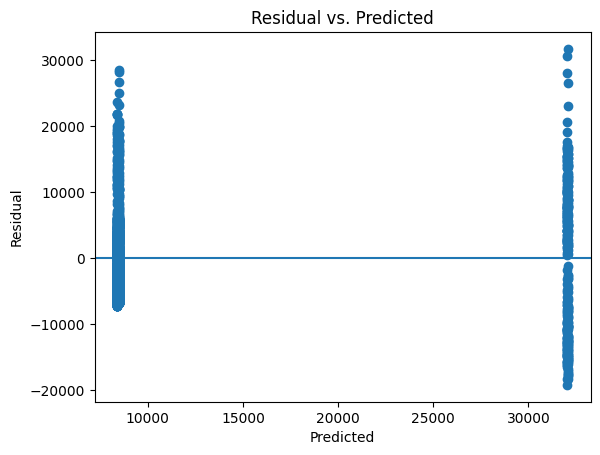

In [6]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

It seems that error variance is higher for the higher values of the target variable. This implies that your error terms aren't homoscedastic. However, deriving conclusions from visuals is only an informal way of figuring out the problem. Thankfully, there are several formal statistical tests that you can use to determine whether there is heteroscedasticity in the error terms.

Below, look at two of them: Bartlett and Levene tests. The null hypothesis for both tests is that the errors are homoscedastic. Both tests can be imported from SciPy's stats module.

In [7]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 78.9785 and p value is 6.28e-19
Levene test statistic value is 6.87294 and p value is 0.0088


The p-values of both tests are lower than `0.05`. So, the test results reject the null hypothesis, which means that your errors are heteroscedastic.

There may be several causes of heteroscedasticity. Examples include outliers in the data and omitted variables that are important in explaining the variance of the target variable. Dealing with outliers and including relevant variables can both help to fix the heteroscedasticity problem. Some fixes to heteroscedasticity include transforming the dependent variable (see [Box-Cox transformation](https://www.statisticshowto.datasciencecentral.com/box-cox-transformation/) and [log transformation](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120293/)) and adding features that target the poorly estimated areas.

If you are working on a dataset that has a limited number of features and your model suffers from heteroscedasticity because of omitted variables, then fixing this problem isn't easy. But keep in mind that even if your model suffers from heteroscedasticity, the estimated coefficients will still be valid. The only problem is with the reliability of some statistical tests like the t-test. Heteroscedasticity may make some estimated coefficients seem to be statistically insignificant. You'll learn about statistical significance in the next lesson.

## Assumption 5: (No perfect) multicollinearity

The previous assumptions were tied to the Gauss-Markov theorem and the advantages of using the best linear unbiased estimator. But this next assumption is a requirement for the model to function at all. In order to perform parameter estimation in the context of a linear model such as OLS, it is important that none of the features are a linear combination of the others. If a feature is a linear combination of the rest, the resulting issue is known as *perfect multicollinearity*.

Why is perfect multicollinearity so problematic? Without getting into the nitty-gritty of linear algebra, estimating unique coefficients in a linear model is self-evidently impossible when a feature is a linear combination of the others. For example, imagine that the "true model" is as follows:

$$ y = 5 + 3x_1 + 4x_2 + 2x_3 + \epsilon$$

Additionally, assume that $x_1 = 2x_2 - x_3$ (perfect multicollinearity). In this situation, it's easy to verify that the following relationship is identical to the previous one:

$$ y = 5 + 2x_1 + 6x_2 + x_3 + \epsilon$$

Naturally, you can extend this technique to produce infinitely many other equivalent variations. Although it is possible to perform prediction when faced with perfect multicollinearity (just use any one of the infinite equivalent solutions), it's impossible to come up with unique parameter estimates. Because OLS aims to find a unique set of parameters corresponding to a unique minimum, it will fail to converge. In actual software implementations, it will most likely produce an error or warning message.

**Note:** This linear combination issue means that caution is needed when you're working with dummy variables. If you create some dummy variables from a categorical variable, then you need to exclude one of them from the model. This is because any one of those dummy variables can be represented as `1` minus the sum of the others—which is perfect multicollinearity.

Beyond the inherent issues of perfect multicollinearity, there are also practical issues that arise when faced with near-perfect multicollinearity in the features. Although the OLS algorithm may converge to a unique set of parameter estimates,  small changes in the data will often produce disproportionately large changes in parameter estimates. This leads to highly inflated estimates of the variance when performing hypothesis testing on the parameters. For these practical reasons, it's usually advisable to identify high multicollinearity and address it through means such as PCA or dropping correlated features.

### Verifying the assumption

The most common technique for quantifying multicollinearity among features is the *variance inflation factor* (VIF). As you may have guessed, the VIF estimates how much the variance of an estimated parameter is increased due to collinearity. The exact mathematical details are beyond the scope of this content, but the basic idea is to perform a linear regression with a chosen feature as the "response" and the other, unchosen features remaining as features. The higher the $R^2$ of the resulting model is (in other words, the more accurately you can predict the chosen feature as a linear combination of the rest), the higher the VIF associated with the chosen feature is. This can be repeated for every feature in the model to calculate VIF scores for each one. Common cutoffs for high VIF are 5 and 10.

## Assumption 6: Uncorrelated error terms

Error terms should be uncorrelated with one another. In other words, the error term for one observation shouldn't predict the error term for another. This type of serial correlation may happen if you omit a relevant variable from the model. So, including that variable into the model can solve this issue.

### Verifying the assumption

To identify whether the error terms are correlated with each other or not, you can graph them. In the graph, you need to observe randomness.

Now, check your medical costs model's errors:

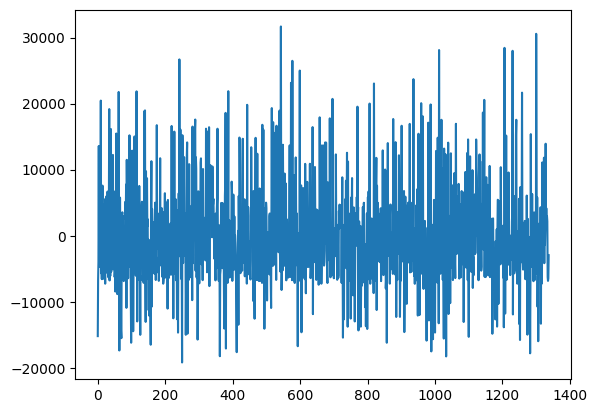

In [8]:
plt.plot(errors)
plt.show()

It seems that the error terms of your model are uncorrelated with each other.

Another way to look at correlations between errors is to use the *autocorrelation function*. This function computes the correlation of a variable with itself. In this case, the order of the errors are the orders of the observations. You can use the `acf()` function from statsmodels as follows:

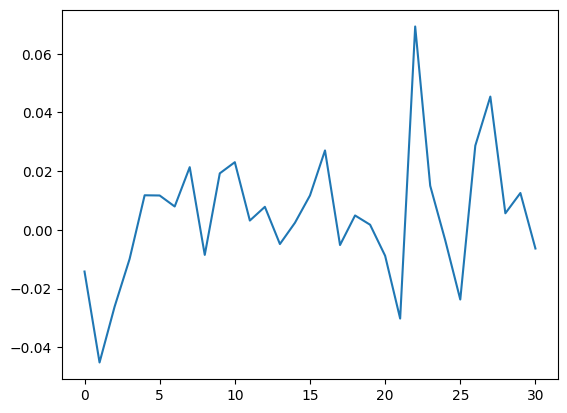

In [9]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

So, the autocorrelation between the errors of your medical costs model is indeed very low—it ranges between `-0.05` and `0.07`.

## A very important remark on the normality of the errors

So far in this lesson, you've learned about six assumptions for OLS regression. Another important consideration is the normality of the error terms. Although this isn't an assumption of the Gauss-Markov theorem, it still can impact your results. Specifically, normality of errors is not required to apply OLS to a linear regression model. But to measure the statistical significance of your estimated coefficients, error terms must be normally distributed. In the next lesson, you'll learn about t-tests and F-tests, which rest upon the normality of the errors.

More often than not, non-normally distributed errors stem from omitted variables. Including the omitted relevant features to the model may help fix the issue. Sometimes, transforming the dependent variable also helps.

There are various ways to check for normality of error terms. An informal way of doing this is by visualizing the errors in a QQ plot or by looking at the histogram, as shown below:

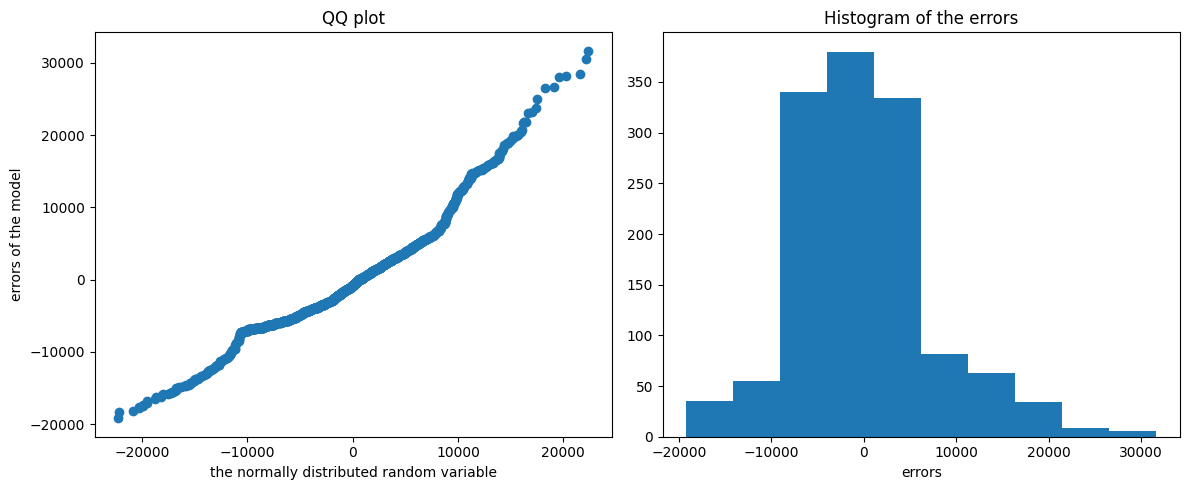

In [10]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # Sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

As can be seen in the charts above, your errors aren't exactly normally distributed. But the QQ plot and the histogram imply that the distribution is not very far away from normal.

Although visualizations give you a first impression about normality, the best way to learn about this is to apply formal statistical tests. To this end, you can use two tests from SciPy's stats module: the *Jarque-Bera test* and the *normal test*. The null hypothesis of both tests is that the errors are normally distributed.

Below, use these tests to determine whether your error terms are normally distributed or not:

In [11]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [12]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 211.8969621698213 and p value is 9.708660146495512e-47
Normality test statistics is 135.84198399398673 and p value is 3.178981278604127e-30


The p-values of both tests indicate that your errors are not normally distributed.